In [1]:
import os
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn

% matplotlib inline

# Maximum Mean Discrepancy Variational Autoencoder (MMD-VAE)

This is a PyTorch implementation of the MMD-VAE, an Information-Maximizing Variational Autoencoder (InfoVAE). It is based off of the TensorFlow implementation published by the author of the original InfoVAE paper.

**References**:
 - https://arxiv.org/abs/1706.02262
 - https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder
 - http://szhao.me/2017/06/10/a-tutorial-on-mmd-variational-autoencoders.html

In [3]:
CUDA = True

ZDIMS = 20
LR = 1e-3
EPOCHS = 30
BATCH_SIZE = 256
SEED = 4
LOG_INTERVAL = 100

In [4]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

## Data

In [5]:
# build train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = True,
                   download = True,
                   transform = transforms.ToTensor()),
    batch_size = BATCH_SIZE,
    shuffle = True,
    **kwargs
)

# build test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = False,
                   transform = transforms.ToTensor()),
    batch_size = BATCH_SIZE,
    shuffle = True,
    **kwargs
)

## Model

In [7]:
NC = 1
NEF = 64
NDF = 64

class Encoder(nn.Module):
    
    def __init__(self, zdims):
        super(Encoder, self).__init__()
        
        self.zdims = zdims
        
        self.model = nn.Sequential(
            
            # input is (NC) x 28 x 28 (MNIST)
            nn.Conv2d(in_channels = NC, out_channels = NEF, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.1, inplace=True),

            # conv layer 2
            nn.Conv2d(in_channels = NEF, out_channels = NEF * 2, kernel_size = 4, stride = 2, padding = 1),
            #nn.BatchNorm2d(NEF * 2),
            nn.LeakyReLU(0.1, inplace=True),

            # conv layer 3
            nn.Conv2d(in_channels = NEF * 2, out_channels = NEF * 4, kernel_size = 4, stride = 2, padding = 1),
            #nn.BatchNorm2d(NEF * 4),
            nn.LeakyReLU(0.1, inplace=True),

            # conv layer 4
            nn.Conv2d(in_channels = NEF * 4, out_channels = 1024, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.1, inplace=True),
            
        )
        
        self.fc = nn.Linear(1024, self.zdims)
    
    
    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        z = self.fc(x)
        return z


class Decoder(nn.Module):
    
    def __init__(self, zdims):
        super(Decoder, self).__init__()
        
        self.zdims = zdims
        
        self.model = nn.Sequential(

            # input is Z (post-fc)
            nn.ConvTranspose2d(in_channels = 1024, out_channels = NDF * 8, kernel_size = 4, stride = 1, padding = 0),
            #nn.BatchNorm2d(NDF * 8),
            nn.ReLU(inplace = True),

            # deconv layer 2
            nn.ConvTranspose2d(in_channels = NDF * 8, out_channels = NDF * 4, kernel_size = 3, stride = 2, padding = 1),
            #nn.BatchNorm2d(NDF * 4),
            nn.ReLU(inplace = True),

            # deconv layer 3
            nn.ConvTranspose2d(in_channels = NDF * 4, out_channels = NDF * 2, kernel_size = 4, stride = 2, padding = 1),
            #nn.BatchNorm2d(NDF * 2),
            nn.ReLU(inplace = True),

            # deconv layer 4
            nn.ConvTranspose2d(in_channels = NDF * 2, out_channels = NC, kernel_size = 4, stride = 2, padding = 1),
            nn.Sigmoid()

        )
    
        self.fc  = nn.Linear(self.zdims, 1024)
        
    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 1024, 1, 1)
        recon_x = self.model(x)
        return recon_x


class MMD_VAE(nn.Module):
    
    def __init__(self, zdims):
        super(MMD_VAE, self).__init__()
        self.encoder = Encoder(zdims)
        self.decoder = Decoder(zdims)
    
    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return z, recon_x

In [8]:
# init model
model = MMD_VAE(zdims = ZDIMS).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

## Train Ops

In [9]:
'''
TensorFlow Implementation from Author
''''''

def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

''';

In [11]:
# in-training sampling (plot / display)
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def loss_function(recon_x, x, z):
    true_samples = torch.randn(BATCH_SIZE, ZDIMS, requires_grad = False).to(device)
    mmd = compute_mmd(true_samples, z)
    nll = (recon_x - x).pow(2).mean()
    loss = nll + mmd
    return loss, nll, mmd

def train(epoch, show_samples = True):
    
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        z, recon_batch = model(data)
        loss, nll, mmd = loss_function(recon_batch, data, z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        # print progress
        if batch_idx % LOG_INTERVAL == 0:
            print("Epoch: {} | Loss: {:.6f} | Negative Log Likelihood: {:.6f} | MMD Loss: {:.6f}".format(epoch,
                                                                                                         loss.item(),
                                                                                                         nll.item(),
                                                                                                         mmd.item())
                 )
        
        # generate samples
        #if show_samples:
        if batch_idx % (LOG_INTERVAL*5) == 0:
            gen_z = torch.randn(100, ZDIMS, requires_grad = False).to(device)
            samples = model.decoder(gen_z)
            samples = samples.view(100, 28, 28, 1)
            plt.imshow(convert_to_display(samples.data), cmap = 'Greys_r')
            plt.show()


def test(epoch):
    
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            z, recon_batch = model(data)
            loss, _, __ = loss_function(recon_batch, data, z)
            test_loss += loss.item()
            
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
    
    test_loss /= len(test_loader.dataset)
    print('\n====> Test set loss: {:.8f}\n\n'.format(test_loss))

## Train
### Z Dims: 20

Epoch: 1 | Loss: 0.236064 | Negative Log Likelihood: 0.233031 | MMD Loss: 0.003033


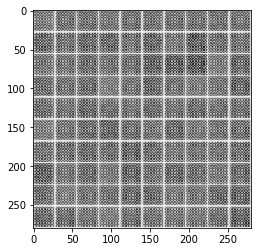

Epoch: 1 | Loss: 0.055471 | Negative Log Likelihood: 0.053003 | MMD Loss: 0.002468
Epoch: 1 | Loss: 0.026185 | Negative Log Likelihood: 0.024986 | MMD Loss: 0.001199

====> Test set loss: 0.00008931


Epoch: 2 | Loss: 0.022437 | Negative Log Likelihood: 0.020992 | MMD Loss: 0.001444


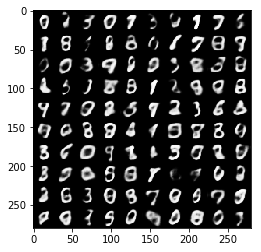

Epoch: 2 | Loss: 0.013832 | Negative Log Likelihood: 0.012818 | MMD Loss: 0.001014
Epoch: 2 | Loss: 0.012664 | Negative Log Likelihood: 0.011658 | MMD Loss: 0.001006

====> Test set loss: 0.00004401


Epoch: 3 | Loss: 0.010924 | Negative Log Likelihood: 0.010154 | MMD Loss: 0.000769


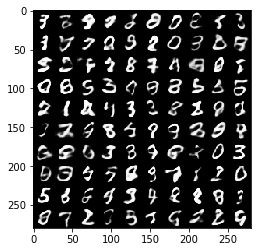

Epoch: 3 | Loss: 0.010124 | Negative Log Likelihood: 0.009067 | MMD Loss: 0.001057
Epoch: 3 | Loss: 0.008760 | Negative Log Likelihood: 0.007374 | MMD Loss: 0.001386

====> Test set loss: 0.00003654


Epoch: 4 | Loss: 0.008423 | Negative Log Likelihood: 0.007573 | MMD Loss: 0.000849


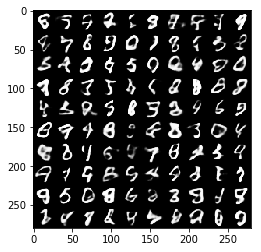

Epoch: 4 | Loss: 0.008635 | Negative Log Likelihood: 0.007653 | MMD Loss: 0.000982
Epoch: 4 | Loss: 0.007839 | Negative Log Likelihood: 0.006859 | MMD Loss: 0.000980

====> Test set loss: 0.00003182


Epoch: 5 | Loss: 0.008076 | Negative Log Likelihood: 0.007374 | MMD Loss: 0.000702


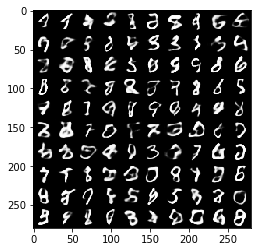

Epoch: 5 | Loss: 0.007931 | Negative Log Likelihood: 0.007011 | MMD Loss: 0.000920
Epoch: 5 | Loss: 0.007221 | Negative Log Likelihood: 0.006575 | MMD Loss: 0.000646

====> Test set loss: 0.00002989


Epoch: 6 | Loss: 0.007241 | Negative Log Likelihood: 0.006165 | MMD Loss: 0.001076


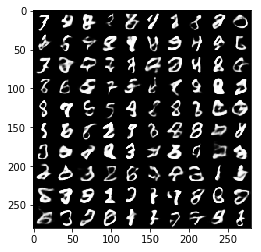

Epoch: 6 | Loss: 0.006142 | Negative Log Likelihood: 0.005381 | MMD Loss: 0.000761
Epoch: 6 | Loss: 0.006622 | Negative Log Likelihood: 0.005709 | MMD Loss: 0.000913

====> Test set loss: 0.00002923


Epoch: 7 | Loss: 0.006865 | Negative Log Likelihood: 0.005912 | MMD Loss: 0.000953


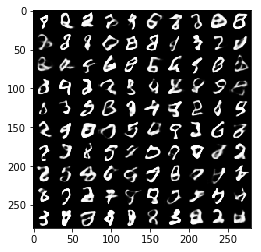

Epoch: 7 | Loss: 0.006082 | Negative Log Likelihood: 0.005220 | MMD Loss: 0.000862
Epoch: 7 | Loss: 0.006779 | Negative Log Likelihood: 0.005451 | MMD Loss: 0.001328

====> Test set loss: 0.00002788


Epoch: 8 | Loss: 0.006541 | Negative Log Likelihood: 0.005323 | MMD Loss: 0.001218


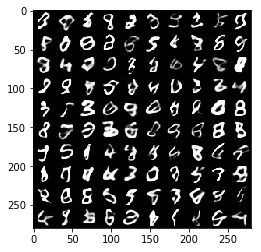

Epoch: 8 | Loss: 0.006409 | Negative Log Likelihood: 0.005391 | MMD Loss: 0.001018
Epoch: 8 | Loss: 0.006311 | Negative Log Likelihood: 0.005389 | MMD Loss: 0.000922

====> Test set loss: 0.00002659


Epoch: 9 | Loss: 0.005947 | Negative Log Likelihood: 0.005091 | MMD Loss: 0.000856


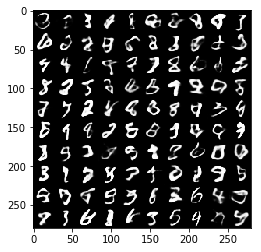

Epoch: 9 | Loss: 0.006080 | Negative Log Likelihood: 0.005604 | MMD Loss: 0.000476
Epoch: 9 | Loss: 0.005779 | Negative Log Likelihood: 0.005134 | MMD Loss: 0.000645

====> Test set loss: 0.00002604


Epoch: 10 | Loss: 0.005965 | Negative Log Likelihood: 0.005025 | MMD Loss: 0.000939


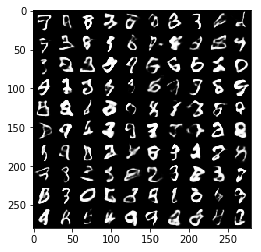

Epoch: 10 | Loss: 0.005444 | Negative Log Likelihood: 0.004778 | MMD Loss: 0.000665
Epoch: 10 | Loss: 0.005358 | Negative Log Likelihood: 0.004629 | MMD Loss: 0.000728

====> Test set loss: 0.00002546


Epoch: 11 | Loss: 0.006284 | Negative Log Likelihood: 0.004596 | MMD Loss: 0.001688


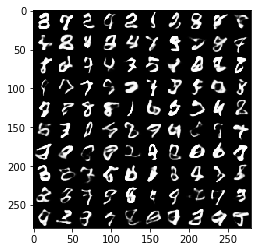

Epoch: 11 | Loss: 0.005485 | Negative Log Likelihood: 0.004616 | MMD Loss: 0.000869
Epoch: 11 | Loss: 0.006343 | Negative Log Likelihood: 0.004722 | MMD Loss: 0.001621

====> Test set loss: 0.00002550


Epoch: 12 | Loss: 0.005895 | Negative Log Likelihood: 0.004769 | MMD Loss: 0.001126


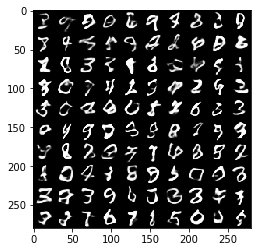

Epoch: 12 | Loss: 0.006279 | Negative Log Likelihood: 0.004721 | MMD Loss: 0.001559
Epoch: 12 | Loss: 0.005328 | Negative Log Likelihood: 0.004640 | MMD Loss: 0.000688

====> Test set loss: 0.00002517


Epoch: 13 | Loss: 0.005790 | Negative Log Likelihood: 0.004503 | MMD Loss: 0.001287


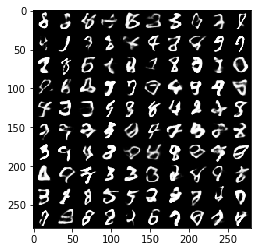

Epoch: 13 | Loss: 0.004766 | Negative Log Likelihood: 0.004317 | MMD Loss: 0.000449
Epoch: 13 | Loss: 0.005383 | Negative Log Likelihood: 0.004340 | MMD Loss: 0.001043

====> Test set loss: 0.00002482


Epoch: 14 | Loss: 0.005447 | Negative Log Likelihood: 0.004181 | MMD Loss: 0.001266


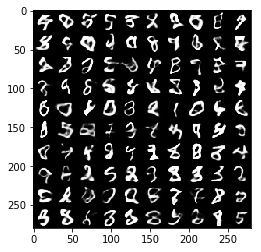

Epoch: 14 | Loss: 0.005347 | Negative Log Likelihood: 0.004489 | MMD Loss: 0.000858
Epoch: 14 | Loss: 0.005265 | Negative Log Likelihood: 0.004396 | MMD Loss: 0.000869

====> Test set loss: 0.00002465


Epoch: 15 | Loss: 0.005412 | Negative Log Likelihood: 0.004397 | MMD Loss: 0.001015


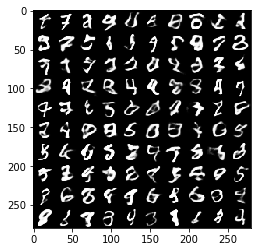

Epoch: 15 | Loss: 0.005232 | Negative Log Likelihood: 0.004351 | MMD Loss: 0.000880
Epoch: 15 | Loss: 0.005131 | Negative Log Likelihood: 0.004243 | MMD Loss: 0.000889

====> Test set loss: 0.00002434


Epoch: 16 | Loss: 0.004679 | Negative Log Likelihood: 0.004179 | MMD Loss: 0.000499


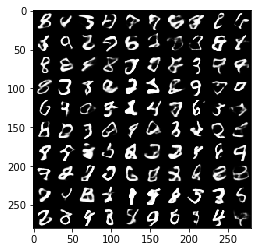

Epoch: 16 | Loss: 0.005627 | Negative Log Likelihood: 0.004218 | MMD Loss: 0.001409
Epoch: 16 | Loss: 0.005176 | Negative Log Likelihood: 0.004474 | MMD Loss: 0.000701

====> Test set loss: 0.00002479


Epoch: 17 | Loss: 0.005380 | Negative Log Likelihood: 0.004308 | MMD Loss: 0.001072


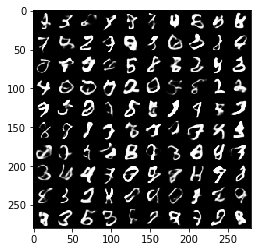

Epoch: 17 | Loss: 0.004721 | Negative Log Likelihood: 0.004004 | MMD Loss: 0.000716
Epoch: 17 | Loss: 0.004837 | Negative Log Likelihood: 0.004057 | MMD Loss: 0.000780

====> Test set loss: 0.00002477


Epoch: 18 | Loss: 0.004417 | Negative Log Likelihood: 0.003945 | MMD Loss: 0.000471


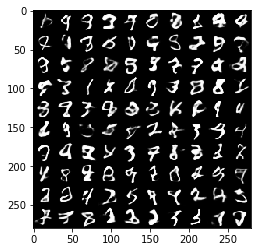

Epoch: 18 | Loss: 0.004882 | Negative Log Likelihood: 0.004063 | MMD Loss: 0.000819
Epoch: 18 | Loss: 0.004926 | Negative Log Likelihood: 0.004220 | MMD Loss: 0.000706

====> Test set loss: 0.00002306


Epoch: 19 | Loss: 0.004547 | Negative Log Likelihood: 0.003997 | MMD Loss: 0.000550


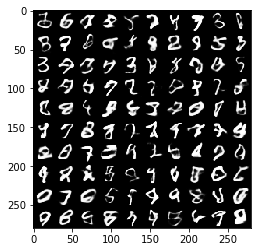

Epoch: 19 | Loss: 0.004620 | Negative Log Likelihood: 0.003937 | MMD Loss: 0.000683
Epoch: 19 | Loss: 0.004620 | Negative Log Likelihood: 0.004137 | MMD Loss: 0.000483

====> Test set loss: 0.00002411


Epoch: 20 | Loss: 0.004995 | Negative Log Likelihood: 0.004075 | MMD Loss: 0.000921


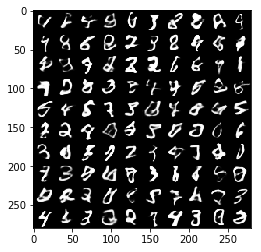

Epoch: 20 | Loss: 0.004800 | Negative Log Likelihood: 0.003773 | MMD Loss: 0.001027
Epoch: 20 | Loss: 0.005123 | Negative Log Likelihood: 0.004034 | MMD Loss: 0.001089

====> Test set loss: 0.00002380


Epoch: 21 | Loss: 0.005251 | Negative Log Likelihood: 0.004099 | MMD Loss: 0.001151


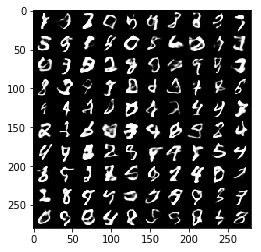

Epoch: 21 | Loss: 0.004985 | Negative Log Likelihood: 0.003923 | MMD Loss: 0.001062
Epoch: 21 | Loss: 0.005049 | Negative Log Likelihood: 0.004068 | MMD Loss: 0.000981

====> Test set loss: 0.00002330


Epoch: 22 | Loss: 0.005682 | Negative Log Likelihood: 0.004014 | MMD Loss: 0.001668


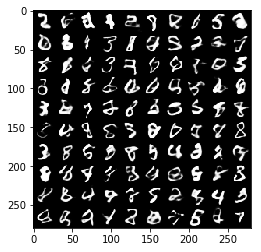

Epoch: 22 | Loss: 0.004659 | Negative Log Likelihood: 0.003589 | MMD Loss: 0.001070
Epoch: 22 | Loss: 0.005239 | Negative Log Likelihood: 0.004165 | MMD Loss: 0.001074

====> Test set loss: 0.00002333


Epoch: 23 | Loss: 0.004920 | Negative Log Likelihood: 0.004107 | MMD Loss: 0.000813


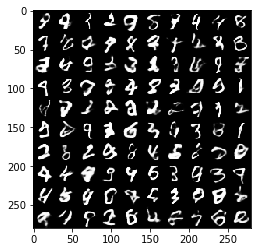

Epoch: 23 | Loss: 0.004454 | Negative Log Likelihood: 0.003741 | MMD Loss: 0.000713
Epoch: 23 | Loss: 0.004374 | Negative Log Likelihood: 0.003687 | MMD Loss: 0.000688

====> Test set loss: 0.00002352


Epoch: 24 | Loss: 0.004363 | Negative Log Likelihood: 0.003893 | MMD Loss: 0.000470


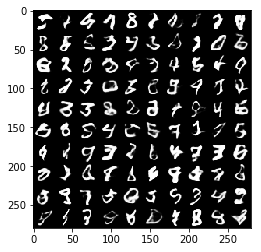

Epoch: 24 | Loss: 0.004375 | Negative Log Likelihood: 0.003785 | MMD Loss: 0.000590
Epoch: 24 | Loss: 0.004814 | Negative Log Likelihood: 0.003643 | MMD Loss: 0.001171

====> Test set loss: 0.00002452


Epoch: 25 | Loss: 0.005085 | Negative Log Likelihood: 0.003574 | MMD Loss: 0.001511


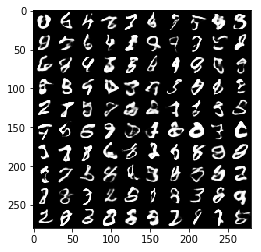

Epoch: 25 | Loss: 0.004593 | Negative Log Likelihood: 0.003578 | MMD Loss: 0.001015
Epoch: 25 | Loss: 0.004482 | Negative Log Likelihood: 0.003716 | MMD Loss: 0.000766

====> Test set loss: 0.00002212


Epoch: 26 | Loss: 0.004401 | Negative Log Likelihood: 0.003675 | MMD Loss: 0.000726


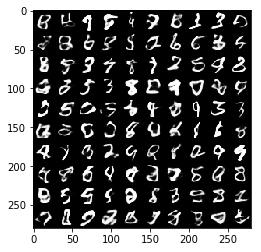

Epoch: 26 | Loss: 0.004205 | Negative Log Likelihood: 0.003792 | MMD Loss: 0.000414
Epoch: 26 | Loss: 0.005200 | Negative Log Likelihood: 0.003764 | MMD Loss: 0.001437

====> Test set loss: 0.00002252


Epoch: 27 | Loss: 0.003998 | Negative Log Likelihood: 0.003389 | MMD Loss: 0.000608


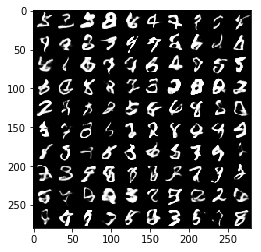

Epoch: 27 | Loss: 0.004340 | Negative Log Likelihood: 0.003765 | MMD Loss: 0.000575
Epoch: 27 | Loss: 0.004305 | Negative Log Likelihood: 0.003655 | MMD Loss: 0.000650

====> Test set loss: 0.00002269


Epoch: 28 | Loss: 0.004813 | Negative Log Likelihood: 0.003698 | MMD Loss: 0.001115


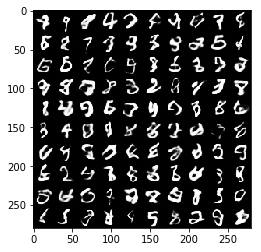

Epoch: 28 | Loss: 0.004252 | Negative Log Likelihood: 0.003591 | MMD Loss: 0.000660
Epoch: 28 | Loss: 0.004351 | Negative Log Likelihood: 0.003408 | MMD Loss: 0.000943

====> Test set loss: 0.00002315


Epoch: 29 | Loss: 0.004172 | Negative Log Likelihood: 0.003565 | MMD Loss: 0.000607


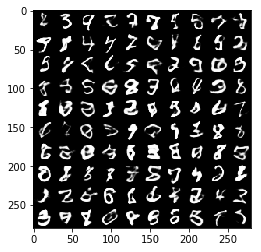

Epoch: 29 | Loss: 0.004456 | Negative Log Likelihood: 0.003508 | MMD Loss: 0.000947
Epoch: 29 | Loss: 0.004656 | Negative Log Likelihood: 0.003626 | MMD Loss: 0.001029

====> Test set loss: 0.00002259


Epoch: 30 | Loss: 0.004498 | Negative Log Likelihood: 0.003622 | MMD Loss: 0.000876


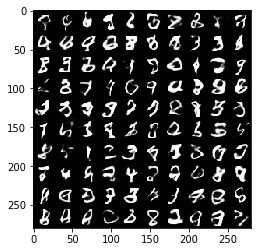

Epoch: 30 | Loss: 0.004465 | Negative Log Likelihood: 0.003656 | MMD Loss: 0.000809
Epoch: 30 | Loss: 0.004412 | Negative Log Likelihood: 0.003508 | MMD Loss: 0.000904

====> Test set loss: 0.00002284




In [11]:
# train model
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

### Z Dims: 2

In [13]:
# # (re)init
# ZDIMS = 2
# model = MMD_VAE(zdims = ZDIMS).to(device)
# optimizer = optim.Adam(model.parameters(), lr = LR)

Epoch: 1 | Loss: 0.392668 | Negative Log Likelihood: 0.233542 | MMD Loss: 0.159126


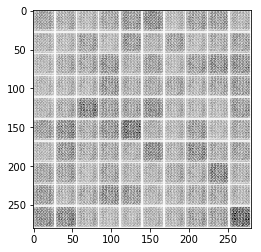

Epoch: 1 | Loss: 0.278462 | Negative Log Likelihood: 0.110183 | MMD Loss: 0.168280
Epoch: 1 | Loss: 0.262696 | Negative Log Likelihood: 0.104198 | MMD Loss: 0.158498

====> Test set loss: 0.00090069


Epoch: 2 | Loss: 0.193992 | Negative Log Likelihood: 0.100425 | MMD Loss: 0.093566


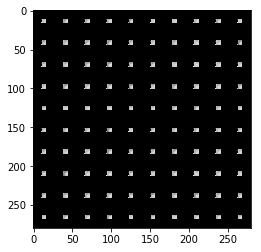

Epoch: 2 | Loss: 0.078640 | Negative Log Likelihood: 0.060637 | MMD Loss: 0.018003
Epoch: 2 | Loss: 0.074276 | Negative Log Likelihood: 0.058942 | MMD Loss: 0.015334

====> Test set loss: 0.00025528


Epoch: 3 | Loss: 0.061920 | Negative Log Likelihood: 0.057864 | MMD Loss: 0.004056


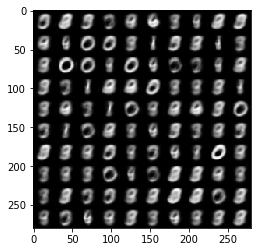

Epoch: 3 | Loss: 0.063171 | Negative Log Likelihood: 0.054997 | MMD Loss: 0.008174
Epoch: 3 | Loss: 0.054662 | Negative Log Likelihood: 0.052322 | MMD Loss: 0.002340

====> Test set loss: 0.00024349


Epoch: 4 | Loss: 0.058364 | Negative Log Likelihood: 0.050978 | MMD Loss: 0.007386


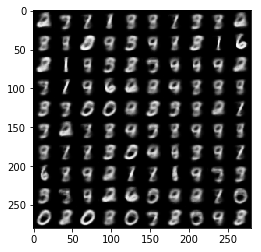

Epoch: 4 | Loss: 0.056843 | Negative Log Likelihood: 0.050198 | MMD Loss: 0.006644
Epoch: 4 | Loss: 0.052286 | Negative Log Likelihood: 0.049744 | MMD Loss: 0.002541

====> Test set loss: 0.00021156


Epoch: 5 | Loss: 0.060609 | Negative Log Likelihood: 0.049813 | MMD Loss: 0.010796


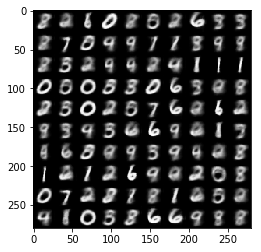

Epoch: 5 | Loss: 0.058116 | Negative Log Likelihood: 0.047448 | MMD Loss: 0.010668
Epoch: 5 | Loss: 0.048696 | Negative Log Likelihood: 0.044233 | MMD Loss: 0.004463

====> Test set loss: 0.00020501


Epoch: 6 | Loss: 0.047754 | Negative Log Likelihood: 0.044782 | MMD Loss: 0.002972


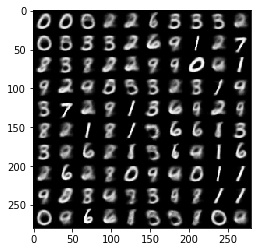

Epoch: 6 | Loss: 0.051927 | Negative Log Likelihood: 0.044156 | MMD Loss: 0.007771
Epoch: 6 | Loss: 0.048910 | Negative Log Likelihood: 0.043478 | MMD Loss: 0.005432

====> Test set loss: 0.00020261


Epoch: 7 | Loss: 0.050935 | Negative Log Likelihood: 0.046198 | MMD Loss: 0.004736


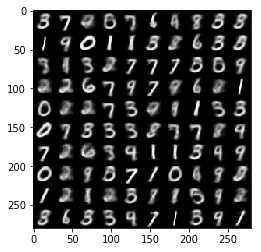

Epoch: 7 | Loss: 0.045627 | Negative Log Likelihood: 0.042980 | MMD Loss: 0.002647
Epoch: 7 | Loss: 0.048688 | Negative Log Likelihood: 0.040961 | MMD Loss: 0.007727

====> Test set loss: 0.00018944


Epoch: 8 | Loss: 0.048433 | Negative Log Likelihood: 0.044400 | MMD Loss: 0.004033


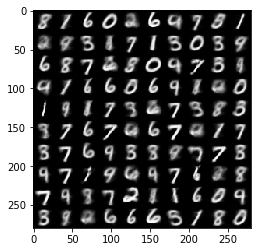

Epoch: 8 | Loss: 0.049136 | Negative Log Likelihood: 0.042137 | MMD Loss: 0.006999
Epoch: 8 | Loss: 0.049770 | Negative Log Likelihood: 0.043576 | MMD Loss: 0.006194

====> Test set loss: 0.00019075


Epoch: 9 | Loss: 0.048229 | Negative Log Likelihood: 0.041319 | MMD Loss: 0.006910


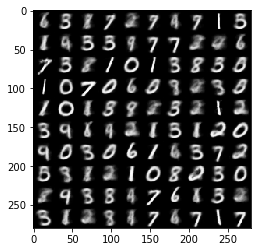

Epoch: 9 | Loss: 0.044304 | Negative Log Likelihood: 0.041456 | MMD Loss: 0.002848
Epoch: 9 | Loss: 0.043628 | Negative Log Likelihood: 0.040570 | MMD Loss: 0.003058

====> Test set loss: 0.00018540


Epoch: 10 | Loss: 0.046370 | Negative Log Likelihood: 0.041536 | MMD Loss: 0.004835


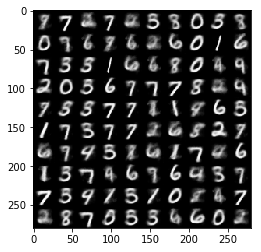

Epoch: 10 | Loss: 0.043287 | Negative Log Likelihood: 0.040129 | MMD Loss: 0.003158
Epoch: 10 | Loss: 0.054231 | Negative Log Likelihood: 0.041537 | MMD Loss: 0.012694

====> Test set loss: 0.00018636


Epoch: 11 | Loss: 0.041005 | Negative Log Likelihood: 0.038168 | MMD Loss: 0.002838


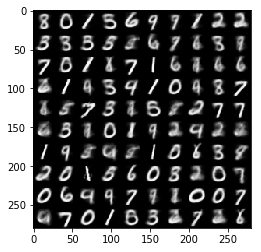

Epoch: 11 | Loss: 0.051031 | Negative Log Likelihood: 0.041600 | MMD Loss: 0.009431
Epoch: 11 | Loss: 0.042232 | Negative Log Likelihood: 0.040062 | MMD Loss: 0.002170

====> Test set loss: 0.00018737


Epoch: 12 | Loss: 0.044499 | Negative Log Likelihood: 0.041344 | MMD Loss: 0.003155


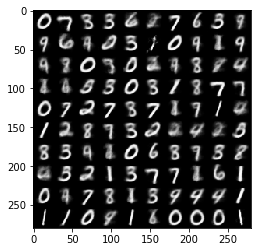

Epoch: 12 | Loss: 0.043197 | Negative Log Likelihood: 0.038081 | MMD Loss: 0.005117
Epoch: 12 | Loss: 0.045201 | Negative Log Likelihood: 0.039105 | MMD Loss: 0.006096

====> Test set loss: 0.00020251


Epoch: 13 | Loss: 0.051379 | Negative Log Likelihood: 0.041105 | MMD Loss: 0.010274


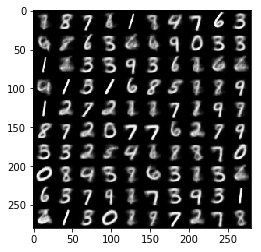

Epoch: 13 | Loss: 0.041752 | Negative Log Likelihood: 0.037931 | MMD Loss: 0.003821
Epoch: 13 | Loss: 0.053404 | Negative Log Likelihood: 0.039223 | MMD Loss: 0.014182

====> Test set loss: 0.00017728


Epoch: 14 | Loss: 0.046001 | Negative Log Likelihood: 0.038853 | MMD Loss: 0.007148


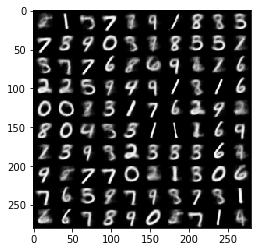

Epoch: 14 | Loss: 0.046858 | Negative Log Likelihood: 0.038361 | MMD Loss: 0.008497
Epoch: 14 | Loss: 0.039412 | Negative Log Likelihood: 0.038125 | MMD Loss: 0.001286

====> Test set loss: 0.00017749


Epoch: 15 | Loss: 0.043349 | Negative Log Likelihood: 0.039128 | MMD Loss: 0.004221


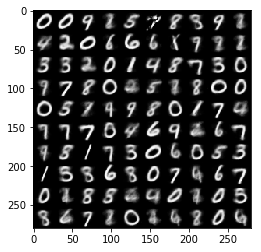

Epoch: 15 | Loss: 0.040454 | Negative Log Likelihood: 0.037574 | MMD Loss: 0.002880
Epoch: 15 | Loss: 0.041532 | Negative Log Likelihood: 0.037570 | MMD Loss: 0.003962

====> Test set loss: 0.00017521


Epoch: 16 | Loss: 0.042534 | Negative Log Likelihood: 0.038493 | MMD Loss: 0.004041


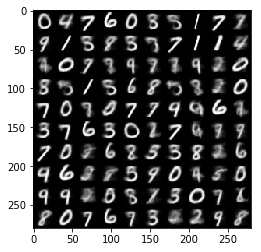

Epoch: 16 | Loss: 0.047499 | Negative Log Likelihood: 0.038450 | MMD Loss: 0.009049
Epoch: 16 | Loss: 0.040448 | Negative Log Likelihood: 0.038080 | MMD Loss: 0.002368

====> Test set loss: 0.00017479


Epoch: 17 | Loss: 0.045451 | Negative Log Likelihood: 0.035484 | MMD Loss: 0.009967


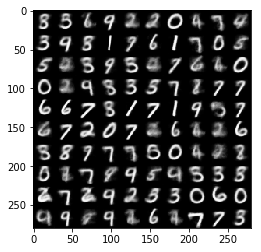

Epoch: 17 | Loss: 0.040578 | Negative Log Likelihood: 0.038175 | MMD Loss: 0.002403
Epoch: 17 | Loss: 0.037203 | Negative Log Likelihood: 0.035352 | MMD Loss: 0.001851

====> Test set loss: 0.00017935


Epoch: 18 | Loss: 0.046467 | Negative Log Likelihood: 0.036948 | MMD Loss: 0.009519


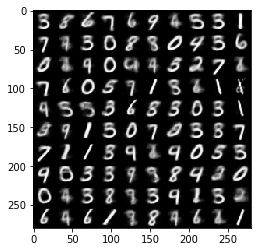

Epoch: 18 | Loss: 0.041432 | Negative Log Likelihood: 0.037704 | MMD Loss: 0.003728
Epoch: 18 | Loss: 0.040851 | Negative Log Likelihood: 0.037121 | MMD Loss: 0.003730

====> Test set loss: 0.00017124


Epoch: 19 | Loss: 0.038714 | Negative Log Likelihood: 0.036445 | MMD Loss: 0.002269


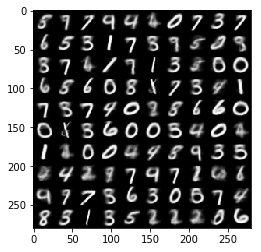

Epoch: 19 | Loss: 0.041957 | Negative Log Likelihood: 0.035983 | MMD Loss: 0.005974
Epoch: 19 | Loss: 0.051399 | Negative Log Likelihood: 0.040663 | MMD Loss: 0.010737

====> Test set loss: 0.00017871


Epoch: 20 | Loss: 0.048200 | Negative Log Likelihood: 0.039399 | MMD Loss: 0.008801


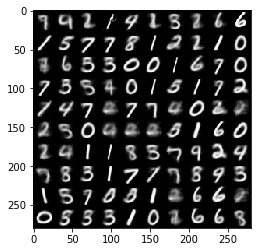

Epoch: 20 | Loss: 0.039847 | Negative Log Likelihood: 0.038083 | MMD Loss: 0.001764
Epoch: 20 | Loss: 0.039556 | Negative Log Likelihood: 0.036166 | MMD Loss: 0.003390

====> Test set loss: 0.00016937


Epoch: 21 | Loss: 0.039071 | Negative Log Likelihood: 0.035230 | MMD Loss: 0.003841


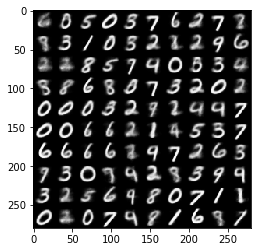

Epoch: 21 | Loss: 0.043820 | Negative Log Likelihood: 0.036270 | MMD Loss: 0.007550
Epoch: 22 | Loss: 0.044053 | Negative Log Likelihood: 0.037039 | MMD Loss: 0.007014
Epoch: 22 | Loss: 0.038073 | Negative Log Likelihood: 0.036644 | MMD Loss: 0.001428

====> Test set loss: 0.00016943


Epoch: 23 | Loss: 0.041556 | Negative Log Likelihood: 0.034647 | MMD Loss: 0.006910


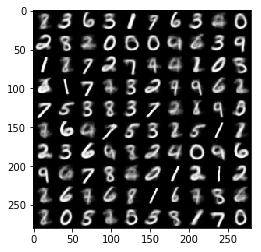

Epoch: 23 | Loss: 0.040405 | Negative Log Likelihood: 0.036006 | MMD Loss: 0.004400
Epoch: 23 | Loss: 0.039819 | Negative Log Likelihood: 0.036695 | MMD Loss: 0.003123

====> Test set loss: 0.00016778


Epoch: 24 | Loss: 0.036072 | Negative Log Likelihood: 0.034994 | MMD Loss: 0.001078


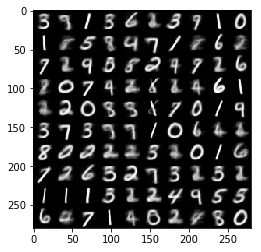

Epoch: 24 | Loss: 0.042643 | Negative Log Likelihood: 0.036028 | MMD Loss: 0.006615
Epoch: 24 | Loss: 0.043897 | Negative Log Likelihood: 0.037964 | MMD Loss: 0.005934

====> Test set loss: 0.00017665


Epoch: 25 | Loss: 0.047255 | Negative Log Likelihood: 0.039286 | MMD Loss: 0.007968


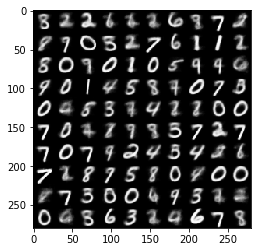

Epoch: 25 | Loss: 0.040424 | Negative Log Likelihood: 0.039472 | MMD Loss: 0.000953
Epoch: 25 | Loss: 0.045196 | Negative Log Likelihood: 0.038404 | MMD Loss: 0.006792

====> Test set loss: 0.00017481


Epoch: 26 | Loss: 0.040669 | Negative Log Likelihood: 0.036071 | MMD Loss: 0.004598


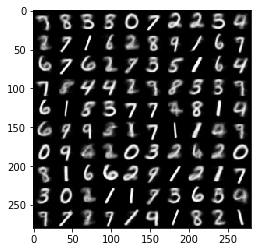

Epoch: 26 | Loss: 0.039944 | Negative Log Likelihood: 0.035561 | MMD Loss: 0.004382
Epoch: 26 | Loss: 0.040479 | Negative Log Likelihood: 0.034139 | MMD Loss: 0.006339

====> Test set loss: 0.00017102


Epoch: 27 | Loss: 0.044917 | Negative Log Likelihood: 0.038127 | MMD Loss: 0.006790


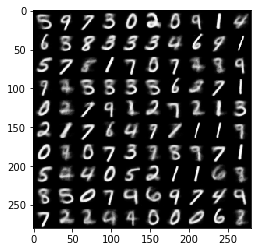

Epoch: 27 | Loss: 0.042112 | Negative Log Likelihood: 0.036835 | MMD Loss: 0.005277
Epoch: 27 | Loss: 0.041548 | Negative Log Likelihood: 0.035449 | MMD Loss: 0.006099

====> Test set loss: 0.00016782


Epoch: 28 | Loss: 0.045869 | Negative Log Likelihood: 0.034520 | MMD Loss: 0.011350


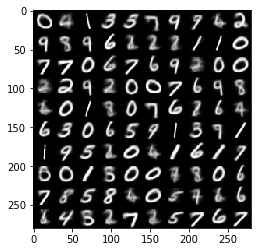

Epoch: 28 | Loss: 0.043930 | Negative Log Likelihood: 0.038384 | MMD Loss: 0.005546
Epoch: 28 | Loss: 0.040187 | Negative Log Likelihood: 0.037074 | MMD Loss: 0.003113

====> Test set loss: 0.00017269


Epoch: 29 | Loss: 0.046021 | Negative Log Likelihood: 0.038674 | MMD Loss: 0.007347


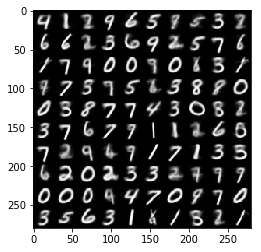

Epoch: 29 | Loss: 0.038902 | Negative Log Likelihood: 0.034738 | MMD Loss: 0.004164
Epoch: 29 | Loss: 0.045620 | Negative Log Likelihood: 0.039456 | MMD Loss: 0.006164

====> Test set loss: 0.00017625


Epoch: 30 | Loss: 0.049602 | Negative Log Likelihood: 0.037127 | MMD Loss: 0.012474


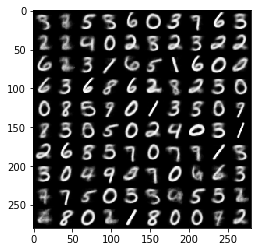

Epoch: 30 | Loss: 0.041974 | Negative Log Likelihood: 0.034683 | MMD Loss: 0.007290
Epoch: 30 | Loss: 0.042755 | Negative Log Likelihood: 0.035537 | MMD Loss: 0.007218

====> Test set loss: 0.00016593




In [11]:
# train model
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

### Z Dims: 5

In [ ]:
# # (re)init
# ZDIMS = 5
# model = MMD_VAE(zdims = ZDIMS).to(device)
# optimizer = optim.Adam(model.parameters(), lr = LR)

Epoch: 1 | Loss: 0.270147 | Negative Log Likelihood: 0.228617 | MMD Loss: 0.041530


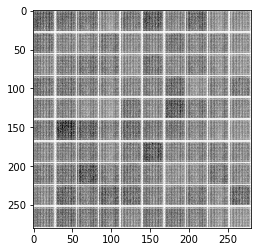

Epoch: 1 | Loss: 0.102443 | Negative Log Likelihood: 0.065564 | MMD Loss: 0.036879
Epoch: 1 | Loss: 0.108512 | Negative Log Likelihood: 0.068598 | MMD Loss: 0.039914

====> Test set loss: 0.00043778


Epoch: 2 | Loss: 0.109092 | Negative Log Likelihood: 0.067643 | MMD Loss: 0.041449


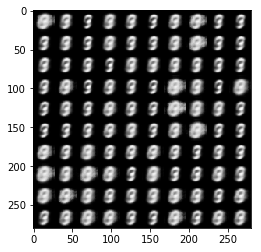

Epoch: 2 | Loss: 0.107634 | Negative Log Likelihood: 0.064339 | MMD Loss: 0.043295
Epoch: 2 | Loss: 0.060667 | Negative Log Likelihood: 0.053813 | MMD Loss: 0.006854

====> Test set loss: 0.00023562


Epoch: 3 | Loss: 0.057444 | Negative Log Likelihood: 0.049734 | MMD Loss: 0.007709


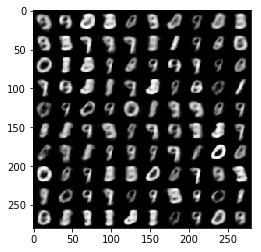

Epoch: 3 | Loss: 0.043677 | Negative Log Likelihood: 0.038831 | MMD Loss: 0.004846
Epoch: 3 | Loss: 0.035074 | Negative Log Likelihood: 0.030956 | MMD Loss: 0.004118

====> Test set loss: 0.00014617


Epoch: 4 | Loss: 0.034750 | Negative Log Likelihood: 0.031137 | MMD Loss: 0.003613


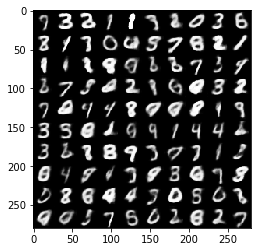

Epoch: 4 | Loss: 0.030481 | Negative Log Likelihood: 0.025798 | MMD Loss: 0.004683
Epoch: 4 | Loss: 0.033757 | Negative Log Likelihood: 0.028086 | MMD Loss: 0.005671

====> Test set loss: 0.00012369


Epoch: 5 | Loss: 0.027980 | Negative Log Likelihood: 0.025117 | MMD Loss: 0.002863


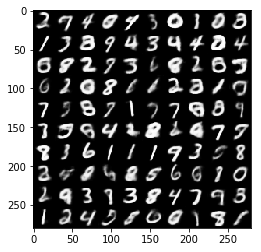

Epoch: 5 | Loss: 0.029596 | Negative Log Likelihood: 0.026539 | MMD Loss: 0.003057
Epoch: 5 | Loss: 0.028800 | Negative Log Likelihood: 0.023895 | MMD Loss: 0.004905

====> Test set loss: 0.00011469


Epoch: 6 | Loss: 0.026168 | Negative Log Likelihood: 0.025025 | MMD Loss: 0.001143


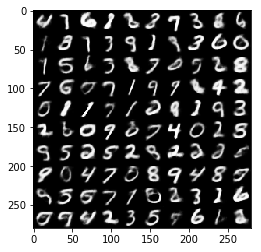

Epoch: 6 | Loss: 0.026179 | Negative Log Likelihood: 0.024448 | MMD Loss: 0.001731
Epoch: 6 | Loss: 0.026624 | Negative Log Likelihood: 0.024604 | MMD Loss: 0.002020

====> Test set loss: 0.00011153


Epoch: 7 | Loss: 0.025924 | Negative Log Likelihood: 0.022999 | MMD Loss: 0.002925


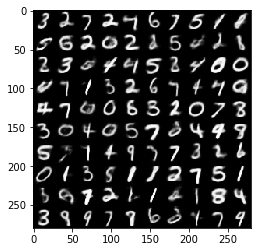

Epoch: 7 | Loss: 0.025876 | Negative Log Likelihood: 0.023343 | MMD Loss: 0.002533
Epoch: 7 | Loss: 0.026166 | Negative Log Likelihood: 0.022655 | MMD Loss: 0.003511

====> Test set loss: 0.00010596


Epoch: 8 | Loss: 0.026601 | Negative Log Likelihood: 0.022465 | MMD Loss: 0.004136


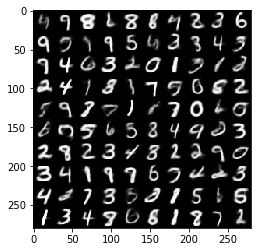

Epoch: 8 | Loss: 0.025881 | Negative Log Likelihood: 0.022735 | MMD Loss: 0.003147
Epoch: 8 | Loss: 0.027321 | Negative Log Likelihood: 0.023512 | MMD Loss: 0.003809

====> Test set loss: 0.00010432


Epoch: 9 | Loss: 0.024172 | Negative Log Likelihood: 0.021072 | MMD Loss: 0.003099


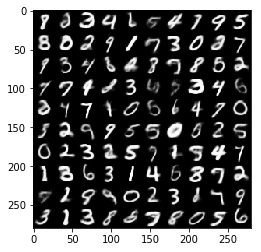

Epoch: 9 | Loss: 0.026553 | Negative Log Likelihood: 0.021277 | MMD Loss: 0.005276
Epoch: 9 | Loss: 0.027986 | Negative Log Likelihood: 0.023188 | MMD Loss: 0.004799

====> Test set loss: 0.00010465


Epoch: 10 | Loss: 0.024608 | Negative Log Likelihood: 0.023334 | MMD Loss: 0.001274


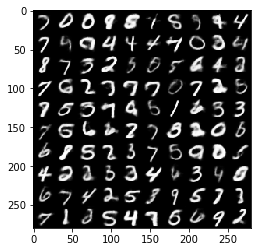

Epoch: 10 | Loss: 0.022771 | Negative Log Likelihood: 0.021325 | MMD Loss: 0.001446
Epoch: 10 | Loss: 0.024428 | Negative Log Likelihood: 0.022330 | MMD Loss: 0.002098

====> Test set loss: 0.00010309


Epoch: 11 | Loss: 0.022713 | Negative Log Likelihood: 0.020632 | MMD Loss: 0.002080


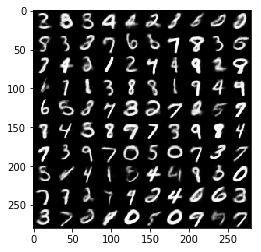

Epoch: 11 | Loss: 0.022609 | Negative Log Likelihood: 0.021098 | MMD Loss: 0.001511
Epoch: 11 | Loss: 0.023844 | Negative Log Likelihood: 0.020979 | MMD Loss: 0.002865

====> Test set loss: 0.00010213


Epoch: 12 | Loss: 0.021692 | Negative Log Likelihood: 0.020560 | MMD Loss: 0.001132


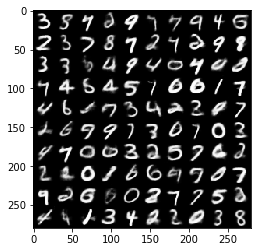

Epoch: 12 | Loss: 0.024952 | Negative Log Likelihood: 0.022822 | MMD Loss: 0.002130
Epoch: 12 | Loss: 0.025866 | Negative Log Likelihood: 0.022216 | MMD Loss: 0.003650

====> Test set loss: 0.00009504


Epoch: 13 | Loss: 0.021580 | Negative Log Likelihood: 0.019912 | MMD Loss: 0.001668


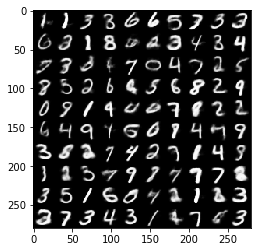

Epoch: 13 | Loss: 0.021887 | Negative Log Likelihood: 0.019885 | MMD Loss: 0.002002
Epoch: 13 | Loss: 0.024677 | Negative Log Likelihood: 0.020245 | MMD Loss: 0.004432

====> Test set loss: 0.00009777


Epoch: 14 | Loss: 0.021442 | Negative Log Likelihood: 0.019329 | MMD Loss: 0.002113


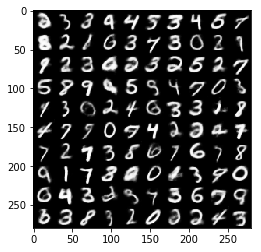

Epoch: 14 | Loss: 0.023268 | Negative Log Likelihood: 0.021571 | MMD Loss: 0.001696
Epoch: 14 | Loss: 0.023052 | Negative Log Likelihood: 0.020454 | MMD Loss: 0.002598

====> Test set loss: 0.00009426


Epoch: 15 | Loss: 0.023105 | Negative Log Likelihood: 0.020202 | MMD Loss: 0.002903


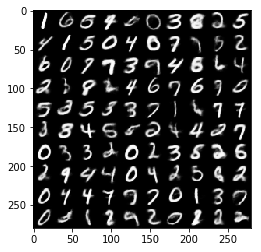

Epoch: 15 | Loss: 0.023099 | Negative Log Likelihood: 0.020024 | MMD Loss: 0.003075
Epoch: 15 | Loss: 0.024957 | Negative Log Likelihood: 0.020970 | MMD Loss: 0.003987

====> Test set loss: 0.00009637


Epoch: 16 | Loss: 0.029064 | Negative Log Likelihood: 0.020353 | MMD Loss: 0.008711


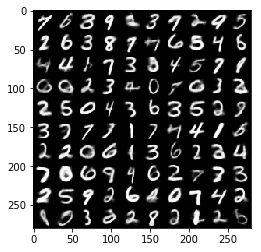

Epoch: 16 | Loss: 0.021178 | Negative Log Likelihood: 0.019907 | MMD Loss: 0.001271
Epoch: 16 | Loss: 0.022492 | Negative Log Likelihood: 0.019756 | MMD Loss: 0.002736

====> Test set loss: 0.00009620


Epoch: 17 | Loss: 0.020981 | Negative Log Likelihood: 0.019088 | MMD Loss: 0.001893


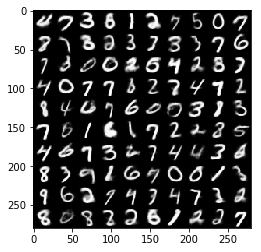

Epoch: 17 | Loss: 0.022600 | Negative Log Likelihood: 0.019794 | MMD Loss: 0.002806
Epoch: 17 | Loss: 0.022629 | Negative Log Likelihood: 0.018942 | MMD Loss: 0.003687

====> Test set loss: 0.00009598


Epoch: 18 | Loss: 0.026397 | Negative Log Likelihood: 0.020870 | MMD Loss: 0.005527


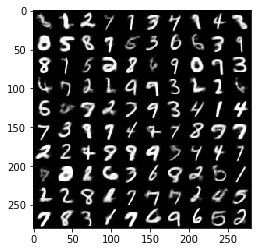

Epoch: 18 | Loss: 0.023887 | Negative Log Likelihood: 0.019811 | MMD Loss: 0.004076
Epoch: 18 | Loss: 0.022054 | Negative Log Likelihood: 0.021125 | MMD Loss: 0.000929

====> Test set loss: 0.00009712


Epoch: 19 | Loss: 0.019753 | Negative Log Likelihood: 0.017828 | MMD Loss: 0.001926


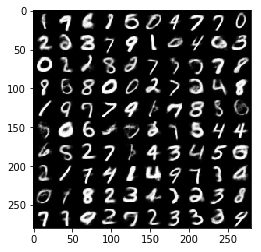

Epoch: 19 | Loss: 0.020678 | Negative Log Likelihood: 0.019774 | MMD Loss: 0.000904
Epoch: 19 | Loss: 0.023649 | Negative Log Likelihood: 0.019863 | MMD Loss: 0.003786

====> Test set loss: 0.00010112


Epoch: 20 | Loss: 0.024689 | Negative Log Likelihood: 0.020655 | MMD Loss: 0.004034


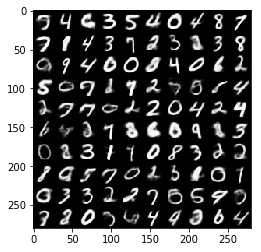

Epoch: 20 | Loss: 0.020848 | Negative Log Likelihood: 0.017365 | MMD Loss: 0.003483
Epoch: 20 | Loss: 0.027070 | Negative Log Likelihood: 0.019558 | MMD Loss: 0.007512

====> Test set loss: 0.00009586


Epoch: 21 | Loss: 0.021909 | Negative Log Likelihood: 0.020277 | MMD Loss: 0.001632


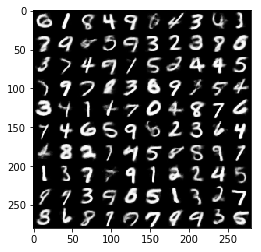

Epoch: 21 | Loss: 0.021281 | Negative Log Likelihood: 0.019604 | MMD Loss: 0.001677
Epoch: 21 | Loss: 0.019991 | Negative Log Likelihood: 0.018177 | MMD Loss: 0.001815

====> Test set loss: 0.00009706


Epoch: 22 | Loss: 0.025055 | Negative Log Likelihood: 0.020631 | MMD Loss: 0.004424


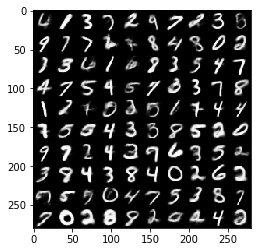

Epoch: 22 | Loss: 0.020580 | Negative Log Likelihood: 0.018055 | MMD Loss: 0.002525
Epoch: 22 | Loss: 0.020913 | Negative Log Likelihood: 0.019275 | MMD Loss: 0.001638

====> Test set loss: 0.00009385


Epoch: 23 | Loss: 0.022324 | Negative Log Likelihood: 0.018387 | MMD Loss: 0.003937


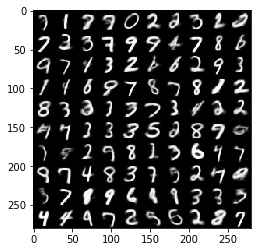

Epoch: 23 | Loss: 0.020321 | Negative Log Likelihood: 0.018776 | MMD Loss: 0.001545
Epoch: 23 | Loss: 0.021047 | Negative Log Likelihood: 0.019193 | MMD Loss: 0.001854

====> Test set loss: 0.00009343


Epoch: 24 | Loss: 0.020610 | Negative Log Likelihood: 0.018643 | MMD Loss: 0.001967


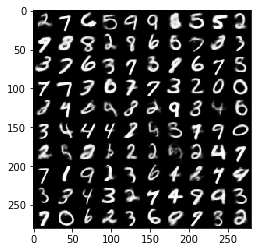

Epoch: 24 | Loss: 0.022341 | Negative Log Likelihood: 0.019990 | MMD Loss: 0.002351
Epoch: 24 | Loss: 0.023098 | Negative Log Likelihood: 0.019864 | MMD Loss: 0.003233

====> Test set loss: 0.00009330


Epoch: 25 | Loss: 0.020238 | Negative Log Likelihood: 0.018305 | MMD Loss: 0.001933


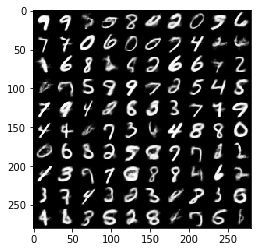

Epoch: 25 | Loss: 0.020084 | Negative Log Likelihood: 0.018445 | MMD Loss: 0.001639
Epoch: 25 | Loss: 0.020574 | Negative Log Likelihood: 0.017660 | MMD Loss: 0.002914

====> Test set loss: 0.00009331


Epoch: 26 | Loss: 0.019839 | Negative Log Likelihood: 0.017987 | MMD Loss: 0.001853


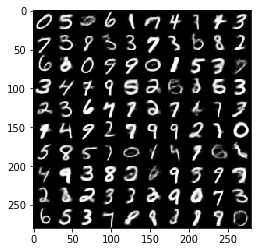

Epoch: 26 | Loss: 0.018822 | Negative Log Likelihood: 0.017621 | MMD Loss: 0.001201
Epoch: 26 | Loss: 0.020620 | Negative Log Likelihood: 0.018378 | MMD Loss: 0.002243

====> Test set loss: 0.00009232


Epoch: 27 | Loss: 0.020914 | Negative Log Likelihood: 0.017323 | MMD Loss: 0.003591


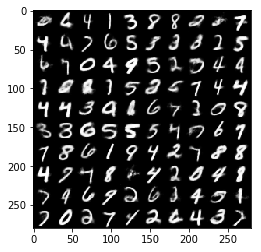

Epoch: 27 | Loss: 0.019032 | Negative Log Likelihood: 0.017435 | MMD Loss: 0.001598
Epoch: 27 | Loss: 0.022607 | Negative Log Likelihood: 0.018907 | MMD Loss: 0.003701

====> Test set loss: 0.00009264


Epoch: 28 | Loss: 0.018499 | Negative Log Likelihood: 0.017284 | MMD Loss: 0.001215


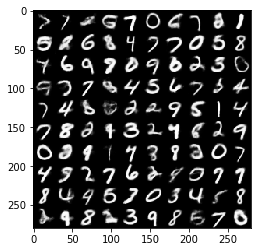

Epoch: 28 | Loss: 0.020617 | Negative Log Likelihood: 0.018279 | MMD Loss: 0.002338
Epoch: 28 | Loss: 0.019764 | Negative Log Likelihood: 0.018551 | MMD Loss: 0.001213

====> Test set loss: 0.00009215


Epoch: 29 | Loss: 0.019328 | Negative Log Likelihood: 0.017086 | MMD Loss: 0.002242


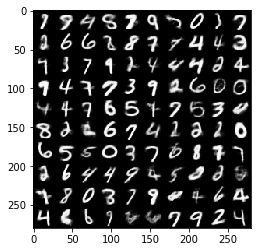

Epoch: 29 | Loss: 0.019959 | Negative Log Likelihood: 0.018404 | MMD Loss: 0.001555
Epoch: 29 | Loss: 0.021030 | Negative Log Likelihood: 0.019533 | MMD Loss: 0.001497

====> Test set loss: 0.00009603


Epoch: 30 | Loss: 0.021639 | Negative Log Likelihood: 0.018542 | MMD Loss: 0.003097


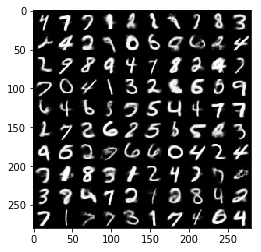

Epoch: 30 | Loss: 0.022149 | Negative Log Likelihood: 0.018168 | MMD Loss: 0.003982
Epoch: 30 | Loss: 0.020180 | Negative Log Likelihood: 0.017512 | MMD Loss: 0.002669

====> Test set loss: 0.00009475




In [12]:
# train model
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

# Results

In the author's tutorial and code, he shows that high-quality samples can be achieved with a minute of training on a subset of 500 images. Unfortunately, with additional training on the entire dataset, we begin to see similar over-fitting that he observes with the traditional VAE (`ZDIMS = 20`).

Fortunately though, the MMD-VAE shows a much stronger ability to reconstruct x, with a test set reconstruction that is not blurry while still maintaining good generalization. Additionally, when comparing the reconstruction quality of the MMD-VAE and the standard VAE at the same latent vector size, the MMD-VAE consistently generates clearer reconstructions.

The MMD-VAE also seems to be more sensitive to the dimensions of z. In my very limited testing, it seems that z dimensions between 5-10 are the best for generating clear and realistic samples on this dataset. This suggests that if this model were to be used for generative tasks, the quantity of `z` dimensions is an important parameter to tune.

In regard to dimension reduction, as with the vanilla (beta-) VAE, it's unclear how well the latent features are disentangled. Next I will use the latent vectors of the different VAE models created thus far (and at various beta levels, when applicable) to test the classification effectiveness/accuracy.

It's also worth noting that I tried a different implementation, one that is more similar to [my vanilla VAE implementation](https://github.com/zacheberhart/Convolutional-Disentangled-Variational-Autoencoder), which included ReLU activations in the `Encoder` and Batch Normalization in both the `Encoder` and `Decoder` (as opposed to Leaky ReLU and no BatchNorm). This implementation performed significantly worse than the one featured in this notebook. I did not do additional testing to isolate whether it was the BatchNorm or ReLU activation that was causing the worse performance but I may do so in the future.